# Importing the libraries

In [7]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.models import Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,BatchNormalization,Dropout,UpSampling2D,Reshape,Input
from keras.datasets import cifar100
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import save_model


# Splitting the dataset into Block 1 and Block 2

We split the CIFAR 100 dataset into two blocks where each block has 50 classess randomly selected.

In [8]:
# Load the CIFAR-100 dataset
(x_all, y_all), (_, _) = cifar100.load_data(label_mode='fine')

# Getting the unique class labels in the dataset
classes = np.unique(y_all)

# Randomly selecting 50 classes
selected_classes = np.random.choice(classes, size=50, replace=False)

# Reshaping the labels to 1D array
y_train = y_all.reshape(-1)

# Splitting the dataset based on the selected classes
selected_indices = np.isin(y_train, selected_classes)
x_block1 = x_all[selected_indices]
y_block1 = y_all[selected_indices]

remaining_classes = np.setdiff1d(classes, selected_classes)
selected_classes = np.random.choice(remaining_classes, size=50, replace=False)

selected_indices = np.isin(y_train, selected_classes)
x_block2 = x_all[selected_indices]
y_block2 = y_all[selected_indices]

169001437/169001437 [==============================] - 8s 0us/step


In [9]:
# Splitting each block into train and test sets
x_block1_train, x_block1_test, y_block1_train, y_block1_test = train_test_split(x_block1, y_block1, test_size=0.2, random_state=42)
x_block2_train, x_block2_test, y_block2_train, y_block2_test = train_test_split(x_block2, y_block2, test_size=0.2, random_state=42)

In [4]:
# Optionally, we have saved these subsets to disk for later use
np.savez_compressed('group1_data.npz', x_train=x_block1_train, y_train=y_block1_train, x_test=x_block1_test, y_test=y_block1_test)
np.savez_compressed('group2_data.npz', x_train=x_block2_train, y_train=y_block2_train, x_test=x_block2_test, y_test=y_block2_test)

# Basic Modelling: For Block 1 Images. Building the Model

**[A] Basic CNN Model**

1) The Sequential Layer is used to build the model structure.

2) The we add 3 Convolutional Layers to the model.

   In the 1st Convolutional layer we use 64 kernels , relu activation function and add some padding to capture the important features.

   In the 2nd Convolutional layer the number of filters are increased to 128 filters , relu activation function and added some padding to capture the important features.

   In the 3rd Convolutional layer the number of filters are increased to 256 filters, relu activation function and added some padding to capture the important features.

  3) BatchNormalization is used to normalize each output of the convolutional layer and feed it to the pooling layer.

  4) The output of the Pooling layer is flattened. MaxPooling is used which takes the maximum value from each receptive feild of the feature map.

  5) Then two fully connected layers are used and one output layer to perform the multi-class classification.

  6) In the final layer the softmax activation function is used as it is used for the multi-class classification.

     To prevent overfitting dropout layers are added as well as BatchNormalization.

        In addition, to increase the accuracy of the model I have tried to increase the complexity of the model by increasing the number of kernels,giving parameters like stride and padding to capture the relevant features in the image.


In [ ]:
# Building the Basic CNN Model
model_cnn = Sequential()

model_cnn.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='valid',input_shape=(32,32,3)))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_cnn.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='valid'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_cnn.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='valid'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_cnn.add(Flatten())

model_cnn.add(Dense(512,activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(256,activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(100,activation='softmax'))

model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 30, 30, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 128)       512       
 chNormalization)                                                
                                                        

In [ ]:
model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Callbacks was used to improve the performance and efficiency of neural network training by preventing overfitting and fine-tuning the learning rate during training.

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),  # Early stopping to prevent overfitting
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)  # Reduce learning rate on plateau
]

In [ ]:
history_cnn = model_cnn.fit(x_block1_train,y_block1_train,epochs=40,validation_data=(x_block1_test,y_block1_test),callbacks=callbacks)

Epoch 1/40
625/625 [==============================] - 122s 196ms/step - loss: 3.2040 - accuracy: 0.1817 - val_loss: 2.8648 - val_accuracy: 0.2634 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 123s 197ms/step - loss: 3.0057 - accuracy: 0.2215 - val_loss: 2.9420 - val_accuracy: 0.2452 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 118s 188ms/step - loss: 2.8419 - accuracy: 0.2587 - val_loss: 2.8079 - val_accuracy: 0.2612 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 117s 187ms/step - loss: 2.6974 - accuracy: 0.2923 - val_loss: 2.4951 - val_accuracy: 0.3382 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 122s 196ms/step - loss: 2.5675 - accuracy: 0.3180 - val_loss: 2.5892 - val_accuracy: 0.3156 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 119s 190ms/step - loss: 2.4524 - accuracy: 0.3476 - val_loss: 2.6150 - val_accuracy: 0.3174 - lr: 0.0010
Epoch 7/40
625/625 [==========================

**[B] Testing with the 'tanh' Activation Function in the Hidden Layers.**

1) The activation function is changed to see how that affects the model's performance.

2) Instead of relu, the tanh activation function is used within the hidden layers.

3) However we can see that the accuracy decreases when we use the tanh function in the hidden layers compared to the other model.

In [ ]:
model_tanh = Sequential()

model_tanh.add(Conv2D(64,kernel_size=(3,3),activation='tanh',padding='valid',input_shape=(32,32,3)))
model_tanh.add(BatchNormalization())
model_tanh.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_tanh.add(Conv2D(128,kernel_size=(3,3),activation='tanh',padding='valid'))
model_tanh.add(BatchNormalization())
model_tanh.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_tanh.add(Conv2D(256,kernel_size=(3,3),activation='tanh',padding='valid'))
model_tanh.add(BatchNormalization())
model_tanh.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_tanh.add(Flatten())

model_tanh.add(Dense(512,activation='tanh'))
model_tanh.add(Dropout(0.5))
model_tanh.add(Dense(256,activation='tanh'))
model_tanh.add(Dropout(0.5))
model_tanh.add(Dense(100,activation='softmax'))

model_tanh.summary()

model_tanh.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization_12 (Ba  (None, 30, 30, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 batch_normalization_13 (Ba  (None, 13, 13, 128)       512       
 tchNormalization)                                               
                                                      

In [ ]:
model_tanh.fit(x_block1_train,y_block1_train,epochs=40,validation_data=(x_block1_test,y_block1_test),callbacks=callbacks)

Epoch 1/40
625/625 [==============================] - 166s 259ms/step - loss: 3.9863 - accuracy: 0.0693 - val_loss: 4.7414 - val_accuracy: 0.0488 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 134s 215ms/step - loss: 3.6288 - accuracy: 0.1086 - val_loss: 4.4122 - val_accuracy: 0.0594 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 129s 207ms/step - loss: 3.4513 - accuracy: 0.1287 - val_loss: 4.1860 - val_accuracy: 0.0456 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 121s 193ms/step - loss: 3.3294 - accuracy: 0.1478 - val_loss: 3.3939 - val_accuracy: 0.1402 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 120s 192ms/step - loss: 3.2137 - accuracy: 0.1717 - val_loss: 3.2071 - val_accuracy: 0.1738 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 120s 192ms/step - loss: 3.1868 - accuracy: 0.1796 - val_loss: 3.2751 - val_accuracy: 0.1744 - lr: 0.0010
Epoch 7/40
625/625 [==========================

**[C] Testing with the Logstic(Sigmoid) Activation function in the Final Layer.**

Here the activation function in the final layer is changed to use the sigmoid activation function instead.

However we can see that the model is overfitting as it gives poor validation accuracy.

Compared to the basic CNN model both have similar validation accuracy, however this model seems to overfit a bit more.

In [ ]:
model_sigmoid = Sequential()

model_sigmoid.add(Conv2D(64,kernel_size=(3,3),activation='relu',padding='valid',input_shape=(32,32,3)))
model_sigmoid.add(BatchNormalization())
model_sigmoid.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_sigmoid.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='valid'))
model_sigmoid.add(BatchNormalization())
model_sigmoid.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_sigmoid.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='valid'))
model_sigmoid.add(BatchNormalization())
model_sigmoid.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model_sigmoid.add(Flatten())

model_sigmoid.add(Dense(512,activation='relu'))
model_sigmoid.add(Dropout(0.5))
model_sigmoid.add(Dense(256,activation='relu'))
model_sigmoid.add(Dropout(0.5))
model_sigmoid.add(Dense(100,activation='sigmoid'))

model_sigmoid.summary()

model_sigmoid.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 batch_normalization_38 (Ba  (None, 30, 30, 64)        256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_85 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 batch_normalization_39 (Ba  (None, 13, 13, 128)       512       
 tchNormalization)                                               
                                                        

In [ ]:
model_sigmoid.fit(x_block1_train,y_block1_train,epochs=40,validation_data=(x_block1_test,y_block1_test),callbacks=callbacks)

Epoch 1/40
625/625 [==============================] - 118s 186ms/step - loss: 3.8441 - accuracy: 0.0945 - val_loss: 3.1268 - val_accuracy: 0.2036 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 110s 175ms/step - loss: 3.2849 - accuracy: 0.1675 - val_loss: 3.0186 - val_accuracy: 0.2146 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 115s 184ms/step - loss: 3.0565 - accuracy: 0.2156 - val_loss: 2.8757 - val_accuracy: 0.2472 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 118s 189ms/step - loss: 2.8873 - accuracy: 0.2482 - val_loss: 2.6249 - val_accuracy: 0.3090 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 109s 175ms/step - loss: 2.7572 - accuracy: 0.2801 - val_loss: 2.4807 - val_accuracy: 0.3414 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 117s 187ms/step - loss: 2.6087 - accuracy: 0.3085 - val_loss: 2.6206 - val_accuracy: 0.3124 - lr: 0.0010
Epoch 7/40
625/625 [==========================

**[D] Adding Skip connections in the Model.**

Here skip connection layers are added to our basic CNN model.

Skip connections are added to the second and third convolutional blocks to preserve spatial information and aid in gradient propagation during training.

Then the skip connections are concatenated with the output of the previous layers, and the concatenated output is passed through additional fully connected layers and finally an output layer with softmax activation for multi-class classification.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Add, Concatenate

# Initialize the model
model = Sequential()

# First convolutional block
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='valid', input_shape=(32,32,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# Second convolutional block with skip connection
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# Third convolutional block with skip connection
model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='valid'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))

# Skip connection from the second convolutional block
skip1 = model.layers[5].output  # Get the output of the second convolutional block
skip2 = model.layers[9].output  # Get the output of the third convolutional block

# Flatten the skip connections to match the output shape of the previous layers
skip1_flatten = Flatten()(skip1)
skip2_flatten = Flatten()(skip2)

# Concatenate skip connections with the output of the previous layers
concatenated_output = Concatenate()([model.layers[-1].output, skip1_flatten, skip2_flatten])

# Fully connected layers
concatenated_output = Dense(256, activation='relu')(concatenated_output)
concatenated_output = Dropout(0.5)(concatenated_output)

# Output layer
output = Dense(100, activation='softmax')(concatenated_output)

# Create the model
model = Model(inputs=model.inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model_48"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_87_input (InputLaye  [(None, 32, 32, 3)]          0         []                            
 r)                                                                                               
                                                                                                  
 conv2d_87 (Conv2D)          (None, 30, 30, 64)           1792      ['conv2d_87_input[0][0]']     
                                                                                                  
 batch_normalization_41 (Ba  (None, 30, 30, 64)           256       ['conv2d_87[0][0]']           
 tchNormalization)                                                                                
                                                                                           

In [ ]:
model.summary()

Model: "model_82"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_199_input (InputLay  [(None, 32, 32, 3)]          0         []                            
 er)                                                                                              
                                                                                                  
 conv2d_199 (Conv2D)         (None, 30, 30, 64)           1792      ['conv2d_199_input[0][0]']    
                                                                                                  
 batch_normalization_222 (B  (None, 30, 30, 64)           256       ['conv2d_199[0][0]']          
 atchNormalization)                                                                               
                                                                                           

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

When comparing the results to the previous models, it has similar validation accuracy along with similar traning accuracy.

In [ ]:
history = model.fit(x_block1_train,y_block1_train,epochs=40,validation_data=(x_block1_test,y_block1_test),callbacks=callbacks)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


625/625 [==============================] - 203s 324ms/step - loss: 3.8948 - accuracy: 0.1010 - val_loss: 3.6283 - val_accuracy: 0.0976 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 210s 336ms/step - loss: 3.2384 - accuracy: 0.1705 - val_loss: 3.3571 - val_accuracy: 0.1804 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 201s 322ms/step - loss: 3.0071 - accuracy: 0.2169 - val_loss: 2.7470 - val_accuracy: 0.2754 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 199s 319ms/step - loss: 2.7956 - accuracy: 0.2526 - val_loss: 2.6749 - val_accuracy: 0.2892 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 208s 333ms/step - loss: 2.6384 - accuracy: 0.2822 - val_loss: 2.5709 - val_accuracy: 0.3196 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 197s 316ms/step - loss: 2.4951 - accuracy: 0.3108 - val_loss: 2.4904 - val_accuracy: 0.3242 - lr: 0.0010
Epoch 7/40
625/625 [==============================] - 195

#### Saving the best model for CNN.
We save the CNN model which has skip connection layers in it, as it seems to overfit less and gives reasonable accuracy as compared to the other models

In [ ]:
save_model(model,'best_cnn_model.h5')

<ipython-input-151-95e3b0cb683e>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model,'best_cnn_model.h5')


We plot the graphs for better visvualization of the accuracy values and the losses for the traning and validation set.

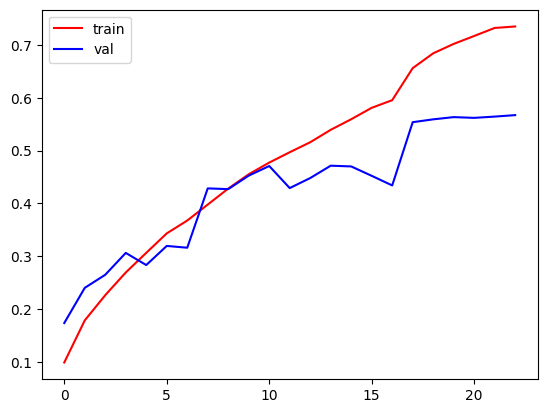

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='val')

plt.legend()
plt.show()

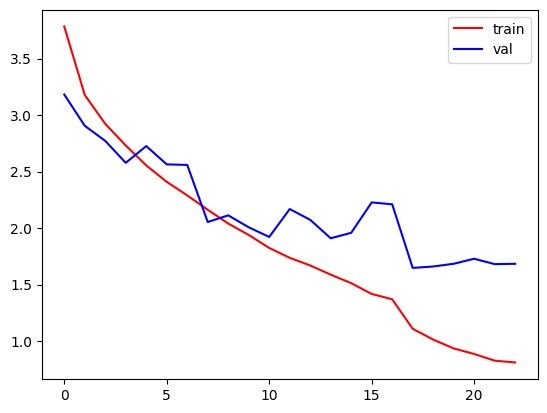

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='val')

plt.legend()
plt.show()

# Autoencoders Modelling : For Block 1 Images

The autoencoder model described below is created:

1) Encoder (CNN):
In the 1st chunck the input shape for the encoder is defined.
Then three convolutional layers are added with increasing number of filters (16, 32, and 64 respectively), each followed by LeakyReLU activation functions. These layers help to extract features from the input image.
After three max-pooling layers are added to reduce the spatial dimensions of the feature maps, helping in retaining the most important features.
The output of the last max-pooling layer represents the encoded (compressed) representation of the input image.

2) Flatten Layer:
It flattens the output of the encoder into a 1D vector, preparing it for the classifier.

3) Classifier:
Two fully connected layers (128 neurons followed by 64 neurons) with ReLU activation functions are used, followed by a final output layer with softmax activation. This part of the model classifies the encoded features into one of the predefined classes (100 in this case).

4) Decoder:
Three upsampling layers are used which increase the spatial dimensions of the encoded representation to match the original input image size.
Two transposed convolutional layers with decreasing number of filters (64 and 32 respectively), each followed by ReLU activation functions and batch normalization are then used. These layers help in reconstructing the original input image.
The final layer with sigmoid activation then reconstructs the color channels of the input image.

 5) Autoencoder Model
 The autoencoder model is defined with the input and output layers. It is then compiled using the Adam optimizer and mean squared error loss, suitable for image reconstruction.

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

# Define the input shape
input_shape = (32, 32, 3)  # Assuming CIFAR-100 images

# Define the encoder part of the autoencoder
def build_encoder(input_shape):
    input_img = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    return Model(input_img, encoded)

# Define the decoder part of the autoencoder
def build_decoder(encoded_shape):
    input_encoded = Input(shape=encoded_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_encoded)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(input_encoded, decoded)

# Build the encoder and decoder models
encoder = build_encoder(input_shape)
decoder = build_decoder(encoder.output_shape[1:])

# Build the autoencoder model by combining encoder and decoder
input_img = Input(shape=input_shape)
encoded_img = encoder(input_img)
decoded_img = decoder(encoded_img)
autoencoder = Model(input_img, decoded_img)

# Compile the autoencoder model
autoencoder.compile(optimizer=Adam(lr=0.001), loss=MeanSquaredError(),metrics=['accuracy'])

# Display the summary of the autoencoder model
autoencoder.summary()

# Train the autoencoder model on block 1
autoencoder.fit(x_block1_train, x_block1_train,
                epochs=15,
                batch_size=128,
                shuffle=True,
                validation_data=(x_block1_test, x_block1_test))


Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 model_44 (Functional)       (None, 8, 8, 32)          20640     
                                                                 
 model_45 (Functional)       (None, 32, 32, 3)         29859     
                                                                 
Total params: 50499 (197.26 KB)
Trainable params: 50115 (195.76 KB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________
Epoch 1/15
157/157 [==============================] - 125s 780ms/step - loss: 20060.8281 - accuracy: 0.4858 - val_loss: 20319.3047 - val_accuracy: 0.4562
Epoch 2/15
157/157 [==============================] - 122s 776ms/step - loss: 20046.1367 - accuracy: 0.5083 - val_loss: 20319.1719

Saving the Autoencoder Model

In [ ]:
save_model(autoencoder,'autoencoder_model.h5')

<ipython-input-31-f82eb3ac1945>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(autoencoder,'autoencoder_model.h5')


# Transfer Learning : Block 2 Images

1) Input Layer: The input layer is defined with the shape of (32,32,3).

2) Encoder Part of AutoEncoder: The part of an existing auto-encoder model is extracted and the each layer is applied sequentially to the input layer (input_layer). The output of this process is then stored in encoder_output.

3) CNN Model: Similarly the CNN model is extarcted and each layer is applied sequentially to the input layer (input_layer). The output of this process is then stored in cnn_output.

4) The output from the encoder (encoder_output) is flattened using the Flatten layer to convert the 3D feature maps into a 1D vector.

5) Concatinating the outputs of Encoder and CNN: the outputs from the Encoder and the CNN are concatenated.

6) Fully connected layers: The concatinaated output are passed to the fully connected Dense layer with 256 neurons and ReLU activation function. A dropout rate of 0.5 was applied along with the dropout regularization to prevent overfitting.

7) Output layer: the output is pased to an output Dense layer with 100 neurons where softmax activation function was used.

8) Creating the transfer learning model: a transfer_model is created using the Model class from Keras library.

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Add, Concatenate, Input

# Define input layer
input_layer = Input(shape=(32, 32, 3))

# Encoder part of the autoencoder
encoder_output = input_layer
for i in range(1, len(autoencoder.layers)):  # Iterate over all layers of the autoencoder
    encoder_output = autoencoder.layers[i](encoder_output)

# Filter only the layers from the CNN model
cnn_layers = [layer for layer in model.layers if isinstance(layer, Conv2D)]

# CNN model
cnn_output = input_layer  # Start with the input layer for CNN
for layer in cnn_layers:  # Iterate over CNN layers
    cnn_output = layer(cnn_output)

# Flatten the output from the encoder
encoder_flattened = Flatten()(encoder_output)

# Flatten the output from the CNN
cnn_flattened = Flatten()(cnn_output)

# Concatenate the outputs of the encoder and CNN
combined_output = Concatenate()([encoder_flattened, cnn_flattened])

# Fully connected layers
combined_output = Dense(256, activation='relu')(combined_output)
combined_output = Dropout(0.5)(combined_output)

# Output layer
output = Dense(100, activation='softmax')(combined_output)

# Create the transfer learning model
transfer_model = Model(inputs=input_layer, outputs=output)

# Compile the transfer learning model
transfer_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
transfer_model.summary()

Model: "model_54"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_64 (InputLayer)       [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_87 (Conv2D)          (None, 30, 30, 64)           1792      ['input_64[0][0]']            
                                                                                                  
 model_44 (Functional)       (None, 8, 8, 32)             20640     ['input_64[0][0]']            
                                                                                                  
 conv2d_88 (Conv2D)          multiple                     73856     ['conv2d_87[11][0]']          
                                                                                           

In [ ]:
transfer_model.fit(x_block2_train, y_block2_train, epochs=50, validation_data=(x_block2_test, y_block2_test),callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/50
625/625 [==============================] - 254s 406ms/step - loss: 3.6690 - accuracy: 0.1048 - val_loss: 3.0921 - val_accuracy: 0.1992 - lr: 0.0010
Epoch 2/50
625/625 [==============================] - 247s 395ms/step - loss: 3.1836 - accuracy: 0.1769 - val_loss: 2.9012 - val_accuracy: 0.2424 - lr: 0.0010
Epoch 3/50
625/625 [==============================] - 258s 413ms/step - loss: 2.9235 - accuracy: 0.2398 - val_loss: 2.9480 - val_accuracy: 0.2460 - lr: 0.0010
Epoch 4/50
625/625 [==============================] - 282s 451ms/step - loss: 2.6486 - accuracy: 0.3000 - val_loss: 2.3734 - val_accuracy: 0.3694 - lr: 0.0010
Epoch 5/50
625/625 [==============================] - 301s 481ms/step - loss: 2.3981 - accuracy: 0.3647 - val_loss: 2.3033 - val_accuracy: 0.3824 - lr: 0.0010
Epoch 6/50
625/625 [==============================] - 291s 465ms/step - loss: 2.1668 - accuracy: 0.4129 - val_loss: 2.1796 - val_accuracy: 0.4148 - lr: 0.0010
Epoch 7/50
625/625 [==========================

Saving the transfer Learning Model

In [ ]:
save_model(transfer_model,'transfer_model.h5')

<ipython-input-146-2a9a68f3f1db>:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(transfer_model,'transfer_model.h5')


# Comparing the CNN model and Auto-Encoder Model on the Block 2 images

The same CNN model is run on block2 dataset images to compare its performance.

In [ ]:
# CNN Model
model_on_block2 = model
model_on_block2.fit(x_block2_train,y_block2_train,epochs=40,validation_data=(x_block2_test,y_block2_test),callbacks=callbacks)

Epoch 1/40
625/625 [==============================] - 206s 329ms/step - loss: 3.8236 - accuracy: 0.0979 - val_loss: 3.6912 - val_accuracy: 0.1182 - lr: 0.0010
Epoch 2/40
625/625 [==============================] - 275s 441ms/step - loss: 3.2147 - accuracy: 0.1603 - val_loss: 3.2045 - val_accuracy: 0.1784 - lr: 0.0010
Epoch 3/40
625/625 [==============================] - 214s 342ms/step - loss: 3.0131 - accuracy: 0.1953 - val_loss: 3.1408 - val_accuracy: 0.1788 - lr: 0.0010
Epoch 4/40
625/625 [==============================] - 231s 369ms/step - loss: 2.8456 - accuracy: 0.2301 - val_loss: 2.5083 - val_accuracy: 0.3136 - lr: 0.0010
Epoch 5/40
625/625 [==============================] - 217s 346ms/step - loss: 2.7078 - accuracy: 0.2585 - val_loss: 2.5966 - val_accuracy: 0.3026 - lr: 0.0010
Epoch 6/40
625/625 [==============================] - 210s 336ms/step - loss: 2.5596 - accuracy: 0.2869 - val_loss: 2.3082 - val_accuracy: 0.3686 - lr: 0.0010
Epoch 7/40
625/625 [==========================

Similary the autoencoder model is tested on block 2 images.

In [14]:
# Testing the AutoEncoder Model on block2 images dataset
auto_encoder_model_on_block2 = autoencoder
auto_encoder_model_on_block2.fit(x_block2_train, x_block2_train,
                epochs=15,
                batch_size=128,
                validation_split=0.2)

Epoch 1/15
125/125 [==============================] - 127s 1s/step - loss: 19946.5723 - accuracy: 0.5040 - val_loss: 19944.9102 - val_accuracy: 0.4518
Epoch 2/15
125/125 [==============================] - 119s 955ms/step - loss: 19931.2441 - accuracy: 0.5506 - val_loss: 19973.0352 - val_accuracy: 0.4756
Epoch 3/15
125/125 [==============================] - 123s 989ms/step - loss: 19930.4336 - accuracy: 0.5436 - val_loss: 19944.5488 - val_accuracy: 0.5494
Epoch 4/15
125/125 [==============================] - 117s 936ms/step - loss: 19930.3008 - accuracy: 0.5208 - val_loss: 19944.3047 - val_accuracy: 0.5382
Epoch 5/15
125/125 [==============================] - 112s 897ms/step - loss: 19930.2891 - accuracy: 0.5180 - val_loss: 19973.3457 - val_accuracy: 0.4328
Epoch 6/15
125/125 [==============================] - 123s 981ms/step - loss: 19930.1895 - accuracy: 0.4802 - val_loss: 19944.2402 - val_accuracy: 0.4343
Epoch 7/15
125/125 [==============================] - 116s 930ms/step - loss: 1